In [45]:
import numpy as np
import librosa
import os
import pandas as pd
import glob
from tqdm import tqdm
from scipy.io import wavfile

from scipy import signal
import numpy as np
import soundfile as sf
os.chdir('../src/')
import config
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import IPython.display as ipd
from sklearn.utils import shuffle
from utils import utils
%matplotlib inline

def clip_power_ref(x):
    return np.clip(np.max(x), 1e-2, 1e7)


def prepare_mfcs(x):
    SAMPLING_RATE = 16000
    N_MELS = 128
    s = librosa.feature.melspectrogram(x, sr=SAMPLING_RATE, n_mels=N_MELS, hop_length=200)
    s_db = librosa.power_to_db(s, ref=clip_power_ref)
    # print(s_db.shape)
    return np.expand_dims(s_db, 2)


def prepare_mfcs_large(x):
    SAMPLING_RATE = 16000
    N_MELS = 128
    s = librosa.feature.melspectrogram(x, sr=SAMPLING_RATE, n_mels=N_MELS*2, hop_length=100)
    s_db = librosa.power_to_db(s, ref=clip_power_ref)
    return np.expand_dims(s_db, 2)


def prepare_cqt(x):
    SAMPLING_RATE = 16000
    N_MELS = 128
    cqt = librosa.core.cqt(x, sr=SAMPLING_RATE, hop_length=128, n_bins=96 * 2,
                           fmin=8000 * (2 ** -8),  # 31.25Hz
                           bins_per_octave=24,
                           filter_scale=0.8)
    s_db = librosa.power_to_db(np.abs(cqt)**2, ref=clip_power_ref)
    # print(s_db.shape)
    return np.expand_dims(s_db, 2)


def computeLogMelSpectrogram(samples, sampleRate = 16000, nMels=128):
    melSpectrum = librosa.feature.melspectrogram(samples, sr=sampleRate, n_mels=nMels)
    
    # Convert to dB, which is a log scale.  Use peak power as reference.
    logMelSpectrogram = librosa.power_to_db(melSpectrum, ref=np.max)
    
    return logMelSpectrogram

def computeMFCC(samples, sampleRate = 16000, nFFT=512, hopLength=256, nMFCC=40):
    mfcc = librosa.feature.mfcc(y=samples, sr=sampleRate, 
                                n_fft=nFFT, hop_length=hopLength, n_mfcc=nMFCC)
    
    # Let's add on the first and second deltas  (what is this really doing?)
    #mfcc = librosa.feature.delta(mfcc, order=2)
    return mfcc

def prepare_fft(x):
    fft = librosa.core.stft(x, n_fft=512, hop_length=128, window="hamming", win_length=512)
    im = librosa.power_to_db(librosa.magphase(fft)[0] ** 2, ref=clip_power_ref)
    return np.expand_dims(im[:96 * 2, :], 2)

In [78]:
def plotRawWave(wav, sampleRate = 16000, figWidth=14, figHeight=4):
    plt.figure(figsize=(figWidth, figHeight))
    plt.plot(np.linspace(0, sampleRate/len(wav), sampleRate), wav)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [sec]")
    plt.show()  # force display while in for loop
    return None
plotRawWave(wav_read)

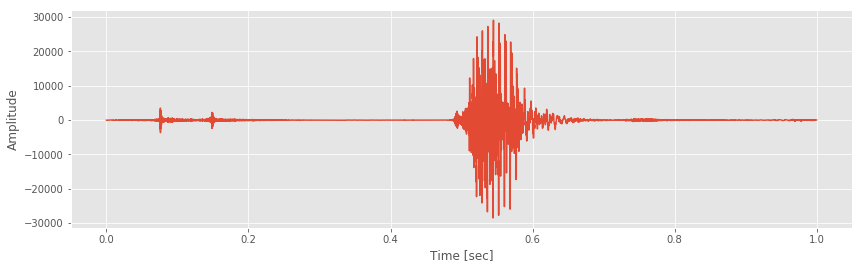

N = 21400

item = gt_train[gt_train['target'].isin(config.allowed_train_labels)]
path = item['path'].tolist()[N]
name = item['target'].tolist()[N]
_, wav_read = wavfile.read(path)

img = prepare_cqt(wav_read)
print(img.shape, name)
plt.imshow(img[:,:,0])


In [80]:
ipd.Audio(data = wav, rate = 16000)

In [3]:
gt_train  = pd.read_csv(config.DATA_FOLDER + 'gt_train.csv')
persons = gt_train['person_id'].unique().tolist()

(99, 161)


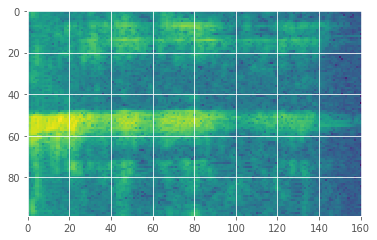

In [74]:
img = utils.log_specgram(wav_read)
plt.imshow(img)
print(img.shape)

In [40]:
N = 3
wav_path = shuffle(gt_train[~gt_train['target'].isin(config.allowed_train_labels)])['path'].tolist()[:N]
wav_list = []
wav = 0
for path in wav_path:
    wav_np = np.zeros(16000,)
    _, wav_read = wavfile.read(path)
    wav_np[:len(wav_read)] = wav_read
    wav_list.append(wav_np)
    
    wav += wav_np
    
wav = wav / float(len(wav_list))

ipd.Audio(data = wav, rate = 16000)
    